In [4]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [5]:


def algo1(state_space, length, start_point=None):
    '''Compute a trajectory following the rules provided:
    
    Statespace: (x,y,z) array containing the point coordinates (x,y)
                   and their values (z)
    Length: int, length of the trajectory
    Start_point: optional, the index of the starting point in state_space
    '''
    
    # Step 1: Start from a place of your choice (either random or specified)
    if start_point is None:
        current_state = np.random.choice(state_space.shape[0])
    else:
        current_state = start_point
    
    traj = [current_state]  # Initialize the trajectory with the starting point
    direction = 'right'  # Initial direction is 'right'

    # Precompute distance matrix for all points in the state space
    dist_matrix = cdist(state_space[:, :2], state_space[:, :2])

    # Maximum number of neighbors to consider
    max_neighbor = 10  # Adjust this as needed

    # Extract values from state space (z values)
    values = state_space[:, 2]
    
    # Define movement directions in terms of vector displacements
    direction_map = {
        'up': np.array([0, 1]),
        'right': np.array([1, 0]),
        'down': np.array([0, -1]),
        'left': np.array([-1, 0])
    }

    def turn_right(current_direction):
        '''Helper function to turn right by 90 degrees'''
        directions = ['up', 'right', 'down', 'left']
        current_idx = directions.index(current_direction)
        return directions[(current_idx + 1) % 4]

    def filter_neighbors_in_direction(neighbors, current_state, direction):
        '''Filter neighbors based on the intended direction'''
        current_pos = state_space[current_state, :2]
        valid_neighbors = []
        
        for neighbor in neighbors:
            neighbor_pos = state_space[neighbor, :2]
            direction_vector = direction_map[direction]
            
            # Check if the neighbor lies in the intended direction
            delta_pos = neighbor_pos - current_pos
            if np.all(delta_pos * direction_vector >= 0):  # Checks if moving in the correct direction
                valid_neighbors.append(neighbor)
        
        return valid_neighbors

    for step in range(length): 
        # Step 2: Find nearest neighbors based on distance
        neighbors = np.argsort(dist_matrix[current_state, :])[1:int(max_neighbor+1)]
        
        # Filter out any neighbors already in the trajectory to avoid looping
        neighbors = [n for n in neighbors if n not in traj[:-1]]
        
        if not neighbors:
            # If all neighbors have been visited, break the loop (or choose a random new point)
           # print(f"Step {step + 1}: All neighbors visited. Stopping early.")
            break
        
        # Find neighbor with smallest z value (state_space[:, 2])
        smallest_neighbor = neighbors[np.argmin(values[neighbors])]
        
        # Step 3: Check the direction and value to determine the next step
        if values[smallest_neighbor] > values[current_state]:
            # If the new value is larger, turn right and take a step in the new direction
            direction = turn_right(direction)
        #    print(f"Turning right at step {step + 1} to {direction}")

            # Filter neighbors in the new direction
            valid_neighbors = filter_neighbors_in_direction(neighbors, current_state, direction)

            if valid_neighbors:
                # Choose the smallest value neighbor in the new direction
                smallest_neighbor = valid_neighbors[np.argmin(values[valid_neighbors])]
            else:
                #print(f"Step {step + 1}: No valid neighbors in the direction {direction}. Stopping.")
                break

        # Move to the next state in the chosen direction
        current_state = smallest_neighbor
        traj.append(current_state)  # Append the new state to the trajectory
        
        # Debug: print the movement details
     #   print(f"Step {step + 1}: Moved to {current_state} (Value: {values[current_state]})")

    return np.array(traj)


In [6]:
no_cells = 200
x = np.random.uniform(0, 1,no_cells)
y = np.random.uniform(0, 1, no_cells)
z = np.random.uniform(-1, 1, no_cells) #this is the values
state_space = np.stack((x,y,z), axis=-1)
#print(state_space)

<IPython.core.display.Javascript object>


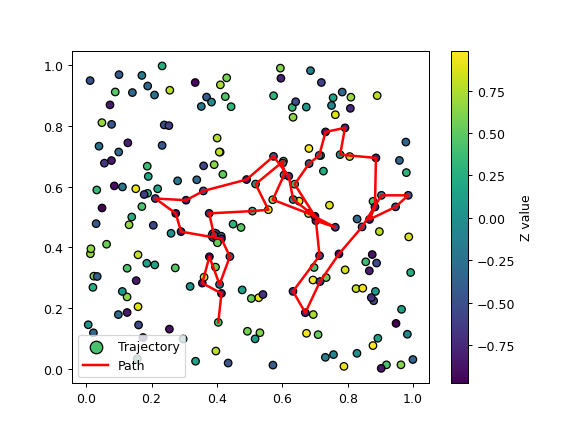

C:\Users\resa\AppData\Local\Temp\ipykernel_16940\277487997.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scat = ax.scatter(x_traj[0], y_traj[0], c=cmap(norm(z_traj[0])), s=100, label='Trajectory', edgecolor='k')


In [9]:
trajectory_length = 1000
traj = algo1(state_space, trajectory_length)


x_traj = state_space[traj, 0]  # x coordinates
y_traj = state_space[traj, 1]  # y coordinates
z_traj = state_space[traj, 2]  # z coordinates (values for coloring)


fig, ax = plt.subplots()

norm = plt.Normalize(vmin=np.min(z_traj), vmax=np.max(z_traj))
cmap = plt.cm.viridis  # You can choose any colormap you prefer, I like this

scat = ax.scatter(x_traj[0], y_traj[0], c=cmap(norm(z_traj[0])), s=100, label='Trajectory', edgecolor='k')

# Line plot for the path of the trajectory
line, = ax.plot([], [], c="r", lw=2, label='Path')

ax.legend()

def update(frame):
   
    scat.set_offsets([x_traj[frame], y_traj[frame]])
    scat.set_facecolor(cmap(norm(z_traj[frame])))  

    line.set_data(x_traj[:frame+1], y_traj[:frame+1])
    
    return scat, line

ani = animation.FuncAnimation(fig, update, frames=trajectory_length, interval=10, repeat=False)


plt.scatter(x, y, c=z, cmap=cmap, edgecolor='k', label='Original Points')
plt.colorbar(label='Z value')  
plt.show()

